In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

{0: 0.017767988252569752, 1: 0.00015436250439165392, 2: 0.0004468051179449675, 3: 0.0006702076769174513, 4: 0.000893610235889935, 5: 0.0011170127948624186, 6: 0.0013404153538349025, 7: 0.0015638179128073862, 8: 0.00178722047177987, 9: 0.002010623030752354, 10: 0.0022340255897248373, 11: 0.002457428148697321, 12: 0.002680830707669805, 13: 0.002904233266642289, 14: 0.0031276358256147724, 15: 0.0033510383845872563, 16: 0.00357444094355974, 17: 0.0037978435025322237, 18: 0.004021246061504708, 19: 0.0042446486204771915, 20: 0.0044680511794496745, 22: 0.004914856297394642, 23: 0.005138258856367126, 24: 0.00536166141533961, 25: 0.005585063974312094, 26: 0.005808466533284578, 27: 0.006031869092257061, 28: 0.006255271651229545, 29: 0.006478674210202029, 30: 0.006702076769174513, 31: 0.006925479328146996, 33: 0.007372284446091964, 34: 0.007595687005064447, 36: 0.008042492123009415, 38: 0.008489297240954383, 39: 0.008712699799926867, 41: 0.009159504917871835, 44: 0.009829712594789285, 46: 0.01027

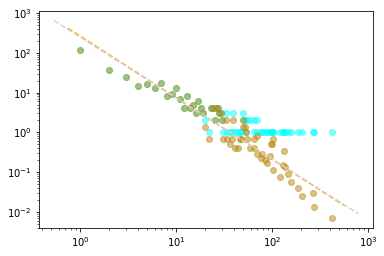

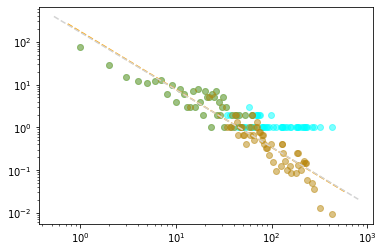

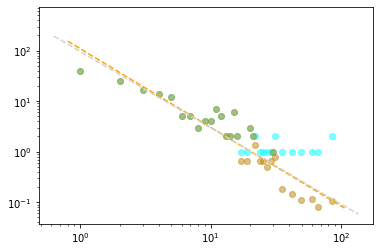

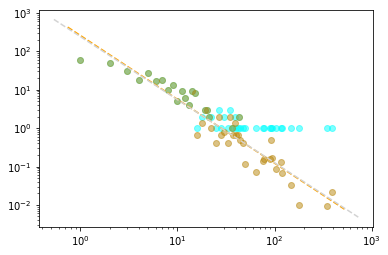

In [2]:
import ast
from collections import Counter, defaultdict
import numpy as np
np.set_printoptions(linewidth=1000, precision=4, suppress=True)
np.random.seed(0)
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import pandas as pd


def abline(axes, slope, intercept, c):
    x_vals = np.array(axes.get_xlim())
    y_vals = np.exp(intercept + slope * np.log(x_vals))
    plt.plot(x_vals, y_vals, '--', c=c)


def letter_to_coord(a, i):
    if a == '#':
        return 0
    return ord(a) - ord('a') + i


edits = ['add', 'del', 'rev', 'sub']
editmatrices = {}
origeditmatrices = {}

for i, edit in enumerate(edits):
    with open('spellcorrect/' + edit + 'confusion.data', 'r') as f:
        C = f.read()
        f.close
    C = ast.literal_eval(C)

    N = sum(C.values())

    C = dict(sorted(C.items(), key=lambda x: x[1]))

    N_c = Counter()
    for pair, c in C.items():
        if (pair[0] != pair[1]) or (edit in ['add', 'del']) or (c > 0):
            N_c[c] += 1

    assert N_c[0] > 0
    assert N == sum([c * n for c, n in N_c.items()])

    R = list(N_c.keys())
    N_r = list(N_c.values())
    Z = {
        R[i]: N_r[i] / (0.5 * (R[i + 1] - R[i - 1]))
        for i in range(1,
                       len(N_c) - 1)
    }
    Z[R[-1]] = N_r[-1] / (R[-1] - R[-2])

    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(list(N_c.keys()), list(N_c.values()), c='cyan', alpha=0.5)
    ax.scatter(list(Z.keys()), list(Z.values()), c='darkgoldenrod', alpha=0.5)
    ax.set_yscale('log')
    ax.set_xscale('log')

    x = np.log(list(Z.keys())).reshape(-1, 1)
    y = np.log(list(Z.values())).reshape(-1, 1)
    c = ['orange', 'lightgray']
    for i, regr in enumerate([LinearRegression(), Ridge()]):
        regr.fit(x, y)
        a_, b_ = regr.intercept_[0], regr.coef_[0][0]
        assert b_ < -1, b_
        abline(ax, b_, a_, c[i])

    N_ = lambda r: np.exp(regr.predict(np.log(r).reshape(1, -1)))
    SGT = {}
    for r in R[1:]:
        r_ = r * np.power((1 + 1 / r), (b_ + 1))
        N_rp1 = N_(r + 1)
        N_r = N_(r)
        assert np.isclose(r_, (r + 1) * N_rp1 / N_r)
        assert r > r_
        std = (r + 1) * np.sqrt(N_rp1 * (1 + N_rp1 / N_r)) / N_r
        if r - r_ > 1.65 * std:
            SGT[r] = r_
        else:
            SGT[r] = r

    default_value = N_c[1] / N
    unnorm = sum(SGT.values())
    P_r = {r: (1 - default_value) * SGT[r] / unnorm for r in SGT}
    P_r[0] = default_value
    print(dict(sorted(P_r.items())))

    index = set()
    columns = set()
    for pair in C:
        index.add(pair[0])
        columns.add(pair[1])
    index = pd.Index(sorted(index))
    columns = pd.Index(sorted(columns))

    matrix = np.ones((index.size, columns.size))
    origmatrix = np.zeros((index.size, columns.size))

    for pair, c in C.items():
        if (pair[0] != pair[1]) or (edit in ['add', 'del']) or (c > 0):
            if edit in ['add', 'del']:
                i = letter_to_coord(pair[0], 1)
            else:
                i = letter_to_coord(pair[0], 0)
            j = letter_to_coord(pair[1], 0)
            matrix[i][j] = P_r[C[pair]] / N_c[C[pair]]
            origmatrix[i][j] = C[pair]

    total_probability = matrix[matrix != 1].sum()
    assert np.isclose(total_probability, 1), total_probability

    matrix = -np.log(matrix)
    matrix /= matrix.mean()

    matrix = pd.DataFrame(matrix, index=index, columns=columns)
    origmatrix = pd.DataFrame(origmatrix, index=index, columns=columns)

    editmatrices[edit] = matrix
    origeditmatrices[edit] = origmatrix

for edit in edits:
    print(edit)
    print(origeditmatrices[edit].iloc[:7, :7])
    print(editmatrices[edit].iloc[:7, :7])

In [3]:
import MinEditDistance_purepython as medpp
import MinEditDistance_numpy as mednp
args0 = ('commrpahendsen', 'comprehension', [1, 1, 1, 1], None, False)
args1 = ('commrpahendsen', 'comprehension', [1, 1, 1, 1], editmatrices, True)

In [4]:
out1, D1, backtrace1 = medpp.MinEditDistance(*args0)
out2, D2, backtrace2 = medpp.MinEditDistance(*args1)
out1, np.flipud(D1), np.flipud(backtrace1), out2, np.flipud(D2), np.flipud(
    backtrace2)

(6,
 array([[14, 13, 12, 11, 10, 10,  9,  9,  8,  7,  6,  6,  6,  6],
        [13, 12, 11, 10,  9,  9,  8,  8,  7,  6,  5,  5,  6,  7],
        [12, 11, 10,  9,  8,  8,  7,  7,  6,  5,  4,  5,  6,  7],
        [11, 10,  9,  8,  7,  7,  6,  6,  5,  4,  4,  5,  6,  7],
        [10,  9,  8,  7,  6,  6,  5,  5,  4,  3,  4,  5,  6,  7],
        [ 9,  8,  7,  6,  5,  5,  4,  4,  3,  4,  5,  6,  7,  8],
        [ 8,  7,  6,  5,  4,  4,  4,  3,  4,  5,  6,  7,  8,  9],
        [ 7,  6,  5,  4,  3,  3,  3,  3,  4,  5,  6,  7,  8,  9],
        [ 6,  5,  4,  3,  2,  2,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 5,  4,  3,  2,  2,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 4,  3,  2,  1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 3,  2,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 2,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
        [ 1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]]),
 arr

In [5]:
out1, D1, backtrace1 = mednp.MinEditDistance(*args0)
out2, D2, backtrace2 = mednp.MinEditDistance(*args1)
out1, np.flipud(D1), np.flipud(backtrace1), out2, np.flipud(D2), np.flipud(
    backtrace2)

(6.0,
 array([[14., 13., 12., 11., 10., 10.,  9.,  9.,  8.,  7.,  6.,  6.,  6.,  6.],
        [13., 12., 11., 10.,  9.,  9.,  8.,  8.,  7.,  6.,  5.,  5.,  6.,  7.],
        [12., 11., 10.,  9.,  8.,  8.,  7.,  7.,  6.,  5.,  4.,  5.,  6.,  7.],
        [11., 10.,  9.,  8.,  7.,  7.,  6.,  6.,  5.,  4.,  4.,  5.,  6.,  7.],
        [10.,  9.,  8.,  7.,  6.,  6.,  5.,  5.,  4.,  3.,  4.,  5.,  6.,  7.],
        [ 9.,  8.,  7.,  6.,  5.,  5.,  4.,  4.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 8.,  7.,  6.,  5.,  4.,  4.,  4.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 7.,  6.,  5.,  4.,  3.,  3.,  3.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 6.,  5.,  4.,  3.,  2.,  2.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 5.,  4.,  3.,  2.,  2.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 4.,  3.,  2.,  1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 3.,  2.,  1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 2.,  1.,  0.,  1.,  2., 

In [6]:
a = get_ipython().run_line_magic('timeit', '-o medpp.MinEditDistance(*args0)')
b = get_ipython().run_line_magic('timeit', '-o medpp.MinEditDistance(*args1)')
c = get_ipython().run_line_magic('timeit', '-o mednp.MinEditDistance(*args0)')
d = get_ipython().run_line_magic('timeit', '-o mednp.MinEditDistance(*args1)')

a.average, b.average, c.average, d.average

260 µs ± 6.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.84 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
920 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.3 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(0.000259699780999134,
 0.007844384192857044,
 0.000920409120284603,
 0.010327892195715062)

In [7]:
wordpairs = []
with open('wordpairs.data', 'r') as f:
    for line in f.readlines():
        wordpairs.append(line[:-1].split(','))

In [8]:
def get_minedits(a, b, n, p, dasr, lr):
    x = np.empty(n**4).reshape(n, n, n, n)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    dasr0 = dasr + np.array([i, j, k, l]) * lr
                    dasr0 *= p / dasr0.sum()
                    x[i][j][k][l], _, _ = medpp.MinEditDistance(
                        a, b, dasr0, editmatrices, True)
    return x


# dasr should converge to (approximately) the same result regardless of
# starting values, and the loss should never increase.
def optimize_dasr(p, dasr_init, lr):
    dasr = p * dasr_init / dasr_init.sum()
    print(dasr)
    prev_loss = None
    loss = None
    grad = None
    for n in range(15):
        x = []
        if grad is not None:
            lr *= 0.99 + 0.01 * grad / (prev_loss - loss + 1e-16)
            print(lr)
        if prev_loss is not None:
            grad = prev_loss - loss + 1e-16
        for wordpair in wordpairs:
            x.append(get_minedits(wordpair[0], wordpair[1], 2, p, dasr, lr))
        x = np.mean(x, axis=0)
        if loss is not None:
            assert np.min(x) - 1e-16 < loss, np.min(x)
            prev_loss = loss
        loss = np.min(x)
        result = np.array(np.unravel_index(np.argmin(x), x.shape))
        dasr += result * lr
        dasr *= p / dasr.sum()
        print(loss, dasr)
        if result.sum() == 0:
            break
    return dasr, loss

In [9]:
np.set_printoptions(linewidth=1000, precision=16, suppress=True)
np.random.seed(1)
scramble = lambda x0: x0 + 0.1 * np.random.rand(4)
def optimize_min_one(x0):
    dasr_loss = []
    dasr_loss.append(optimize_dasr(np.sum(x0) / np.min(x0), x0, 0.01))
    dasr_loss.append(optimize_dasr(np.sum(x0) / np.min(x0), scramble(x0), 0.1))
    dasr_loss = np.array(dasr_loss)
    x = dasr_loss[np.argmin(dasr_loss[:, 1])]
    x0 = x[0]
    if np.isclose(np.min(x0), 1):
        return x
    return optimize_min_one(x0)

In [10]:
optimize_min_one(np.array([1., 1., 1., 1.]))
# seed=0: array([array([1.4931956965189737, 1.                , 1.8964928872549733, 2.618691365188043 ]), 0.03709405165824454], dtype=object)

[1. 1. 1. 1.]
0.07104837423886454 [0.9950248756218907 0.9950248756218907 1.0049751243781095 1.0049751243781095]
0.0708537000585518 [0.9900745031063588 0.9900745031063588 1.0099254968936413 1.0099254968936413]
0.07066443072287226 [0.9851487593098097 0.9851487593098097 1.0148512406901902 1.0148512406901902]
0.010002855636711463
0.07048040848972091 [0.980246129051138  0.980246129051138  1.0197538709488623 1.0197538709488623]
0.010005707792573369
0.07030024190180972 [0.9753665128918095 0.9753665128918095 1.0246334871081904 1.0246334871081904]
0.010007849058613436
0.07012033287343673 [0.9705101533296222 0.9705101533296222 1.0294898466703777 1.0294898466703777]
0.01000799233196693
0.06994546527926648 [0.9656779047964459 0.9656779047964459 1.0343220952035541 1.0343220952035541]
0.010010877636993428
0.06977438279131919 [0.968417748745303  0.958481474229568  1.0365503885125646 1.0365503885125646]
0.01001309248877023
0.06960711397919385 [0.9635934734596396 0.9537066975447305 1.041349914497815  1

array([array([1.4865255068875494, 1.                , 1.8887883894859618, 2.6185290997841335]), 0.03716784230153717], dtype=object)

In [11]:
import tensorflow as tf


def string_to_sparse_tensor(string):
    values = bytearray(string.encode())
    indices = [[i, 0] for i in range(len(string))]
    shape = (len(string), 2)
    return tf.sparse.transpose(tf.SparseTensor(indices, values, shape))


def min_edit_distance(hypothesis, truth):
    hypothesis = string_to_sparse_tensor(hypothesis)
    truth = string_to_sparse_tensor(truth)
    return tf.edit_distance(hypothesis, truth, normalize=True)[0].numpy()


min_edit_distance('eieo', 'ieio')

0.5